In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn import datasets as ds
from PIL import Image
import networkx as nx
from sklearn import cluster
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

### Working with graphs

[[ 0.  1.  0.  0.  1.  0.  0.  0.  1.  1.]
 [ 1.  0.  0.  0.  0.  1.  1.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  1.  1.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.  1.  1.  1.  1.  1.]
 [ 0.  1.  0.  1.  1.  0.  0.  1.  0.  1.]
 [ 0.  1.  1.  1.  1.  0.  0.  0.  1.  0.]
 [ 0.  1.  0.  0.  1.  1.  0.  0.  0.  1.]
 [ 1.  0.  0.  1.  1.  0.  1.  0.  0.  1.]
 [ 1.  0.  0.  0.  1.  1.  0.  1.  1.  0.]]


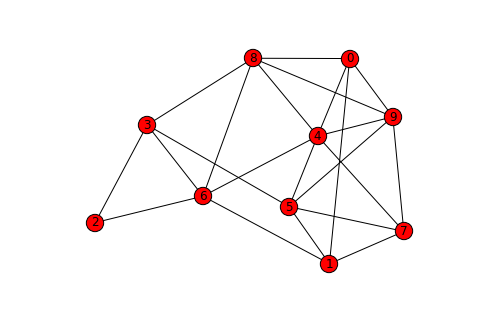

In [40]:
G = nx.random_graphs.erdos_renyi_graph(10,0.5)
nx.draw(G)
#adjacency matrix
W = np.array(nx.adjacency_matrix(G))
print W

In [46]:
# compute Laplacian
D = np.diag(np.sum(W,axis=1))
print "Degree"
print D
print "Laplacian"
L = D - W
print L

Degree
[[ 4.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  4.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  2.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  4.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  6.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  5.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  5.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  4.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  5.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  5.]]
Laplacian
[[ 4. -1.  0.  0. -1.  0.  0.  0. -1. -1.]
 [-1.  4.  0.  0.  0. -1. -1. -1.  0.  0.]
 [ 0.  0.  2. -1.  0.  0. -1.  0.  0.  0.]
 [ 0.  0. -1.  4.  0. -1. -1.  0. -1.  0.]
 [-1.  0.  0.  0.  6. -1. -1. -1. -1. -1.]
 [ 0. -1.  0. -1. -1.  5.  0. -1.  0. -1.]
 [ 0. -1. -1. -1. -1.  0.  5.  0. -1.  0.]
 [ 0. -1.  0.  0. -1. -1.  0.  4.  0. -1.]
 [-1.  0.  0. -1. -1.  0. -1.  0.  5. -1.]
 [-1.  0.  0.  0. -1. -1.  0. -1. -1.  5.]]


[  6.66133815e-16   1.36965676e+00   7.85502687e+00   6.81683009e+00
   6.31188086e+00   5.79196718e+00   5.00000000e+00   3.18726027e+00
   3.75084440e+00   3.91653356e+00]
[[ 0.31622777  0.23219457 -0.24454267  0.10818666  0.32706565  0.23836911
  -0.38729833 -0.43376098 -0.52198162  0.01323035]
 [ 0.31622777  0.177191    0.31032915 -0.07348355 -0.33428323 -0.05830646
  -0.06454972  0.35736325 -0.39073103 -0.60597733]
 [ 0.31622777 -0.77911906  0.0271235  -0.13026322 -0.05114499 -0.04096097
  -0.06454972  0.18629541 -0.34381886  0.33747835]
 [ 0.31622777 -0.29770551  0.22648515  0.228016    0.0344588   0.36362732
  -0.38729833 -0.12420394  0.57122633 -0.28800387]
 [ 0.31622777  0.15978308  0.65955564 -0.13249574  0.51004165 -0.21883502
   0.25819889 -0.11001399  0.05026646  0.18047962]
 [ 0.31622777  0.15174133 -0.39146707 -0.29397117  0.18858497 -0.52178819
  -0.38729833  0.29497144  0.30393122  0.00997567]
 [ 0.31622777 -0.19340692 -0.38529398  0.3994398   0.1860723  -0.20830467
  

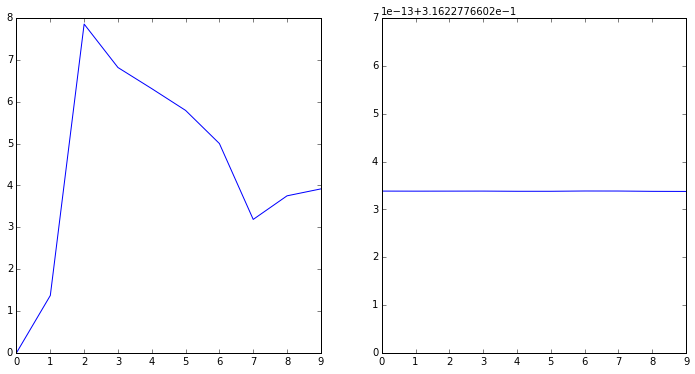

In [58]:
#eigen vector analysis of the Laplacian matrix
e,v = np.linalg.eig(L)
print e
print v
fig = plt.figure(figsize=[12,6])
ax = fig.gca
plt.subplot(121)
plt.plot(e)
plt.subplot(122)
plt.plot(v[:,0])

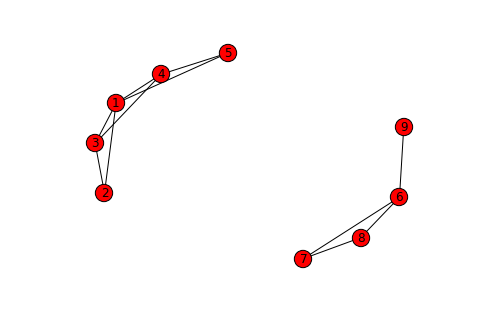

In [93]:
# create a graph with disconnected components
G = nx.Graph()
G.add_edges_from([[1,2],[1,3],[1,4],[2,3],[3,4],[4,5],[1,5],[6,7],[7,8],[6,8],[6,9],[9,6]])
nx.draw(G)
#adjacency matrix
W = np.array(nx.adjacency_matrix(G))

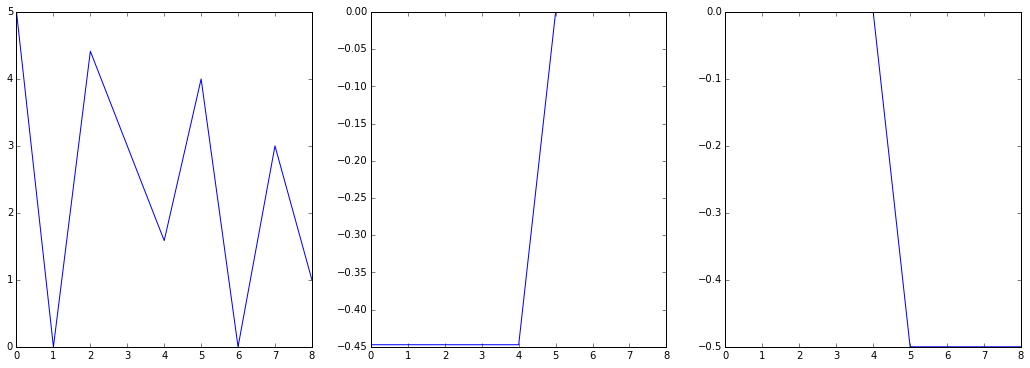

In [96]:
# compute Laplacian
D = np.diag(np.sum(W,axis=1))
L = D - W
#eigen vector analysis of the Laplacian matrix
e,v = np.linalg.eig(L)
fig = plt.figure(figsize=[18,6])
ax = fig.gca
plt.subplot(131)
plt.plot(e)
i = np.where(e < 10e-6)[0]
plt.subplot(132)
plt.plot(v[:,i[0]])
plt.subplot(133)
plt.plot(v[:,i[1]])

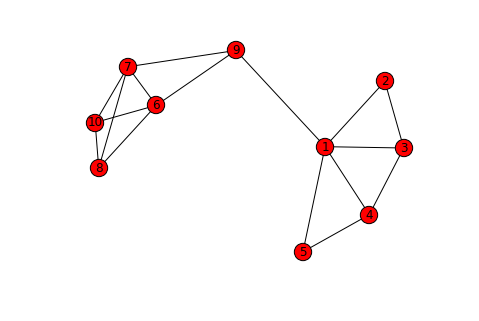

In [99]:
# create a graph with nearly disconnected components
G = nx.Graph()
G.add_edges_from([[1,2],[1,3],[1,4],[2,3],[3,4],[4,5],[1,5],[6,7],[7,8],[6,8],[6,9],[9,6],[7,10],[8,10],[6,10],[9,1],[7,9]])
nx.draw(G)
#adjacency matrix
W = np.array(nx.adjacency_matrix(G))

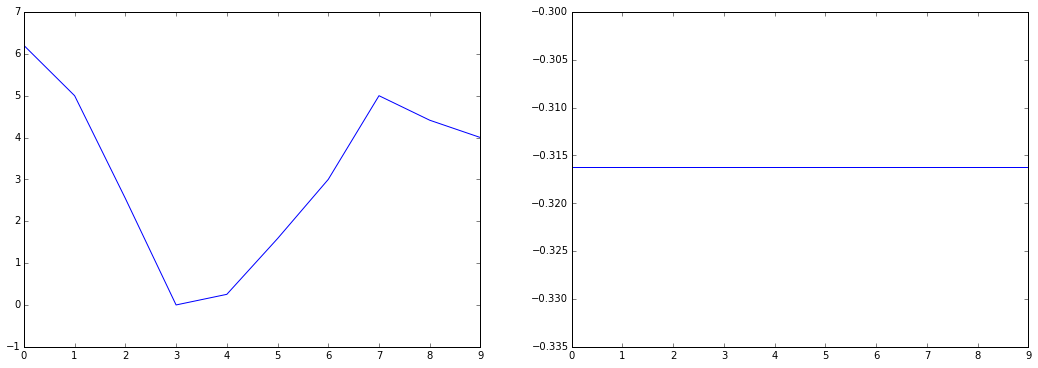

In [104]:
# compute Laplacian
D = np.diag(np.sum(W,axis=1))
L = D - W
#eigen vector analysis of the Laplacian matrix
e,v = np.linalg.eig(L)
fig = plt.figure(figsize=[18,6])
ax = fig.gca
plt.subplot(121)
plt.plot(e)
i = np.where(e < 10e-6)[0]
plt.subplot(122)
plt.plot(v[:,i[0]])


### Spectral Clustering Illustration

(-1.2254645299595175,
 1.2393764851127851,
 -1.1896347225493169,
 1.1793091356763761)

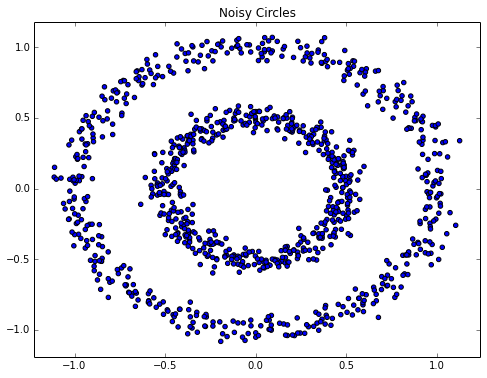

In [166]:
# generate data
X,c = ds.make_circles(n_samples=1000, factor=.5,noise=.05)
# plot
fig = plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], X[:, 1])
plt.title("Noisy Circles")
plt.axis('tight')

We first show how kMeans clustering is not suitable for such kind of data

In [156]:
# perform k means clustering on this data
kmeans = cluster.KMeans(init='k-means++', n_clusters=2)
kmeans.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances=True, random_state=None, tol=0.0001,
    verbose=0)

(-1.1865752395608886,
 1.1794249221142756,
 -1.2472864412359059,
 1.2142168009515406)

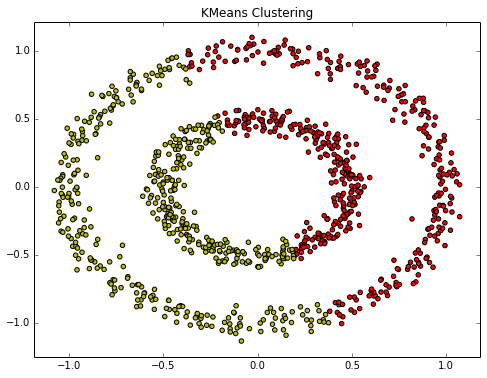

In [152]:
c = kmeans.labels_
# plot with cluster assignments
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X[np.where(c == 0), 0], X[np.where(c == 0), 1],c= 'r')
ax.scatter(X[np.where(c == 1), 0], X[np.where(c == 1), 1],c= 'y')
ax.set_title("KMeans Clustering")
plt.axis('tight')

Now let us try Spectral Clustering

In [157]:
spectral = cluster.SpectralClustering(n_clusters=2,eigen_solver='arpack',affinity="nearest_neighbors")
spectral.fit(X)

SpectralClustering(affinity='nearest_neighbors', assign_labels='kmeans',
          coef0=1, degree=3, eigen_solver='arpack', eigen_tol=0.0,
          gamma=1.0, kernel_params=None, n_clusters=2, n_init=10,
          n_neighbors=10, random_state=None)

(-1.1857284653673403,
 1.1793845995336305,
 -1.2444638605907445,
 1.21408239234939)

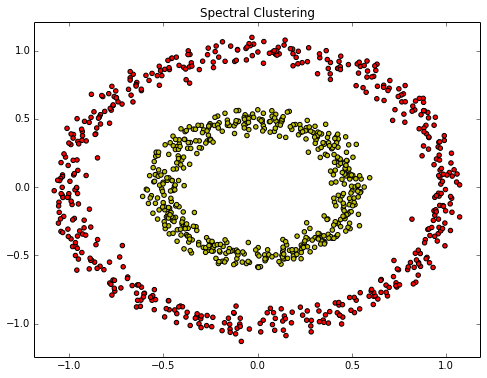

In [158]:
c = spectral.labels_
# plot with cluster assignments
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X[np.where(c == 0), 0], X[np.where(c == 0), 1],c= 'r')
ax.scatter(X[np.where(c == 1), 0], X[np.where(c == 1), 1],c= 'y')
ax.set_title("Spectral Clustering")
plt.axis('tight')

## Comparing different clustering algorithms on toy datasets 
Adapted from the sklearn page on clustering
http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html

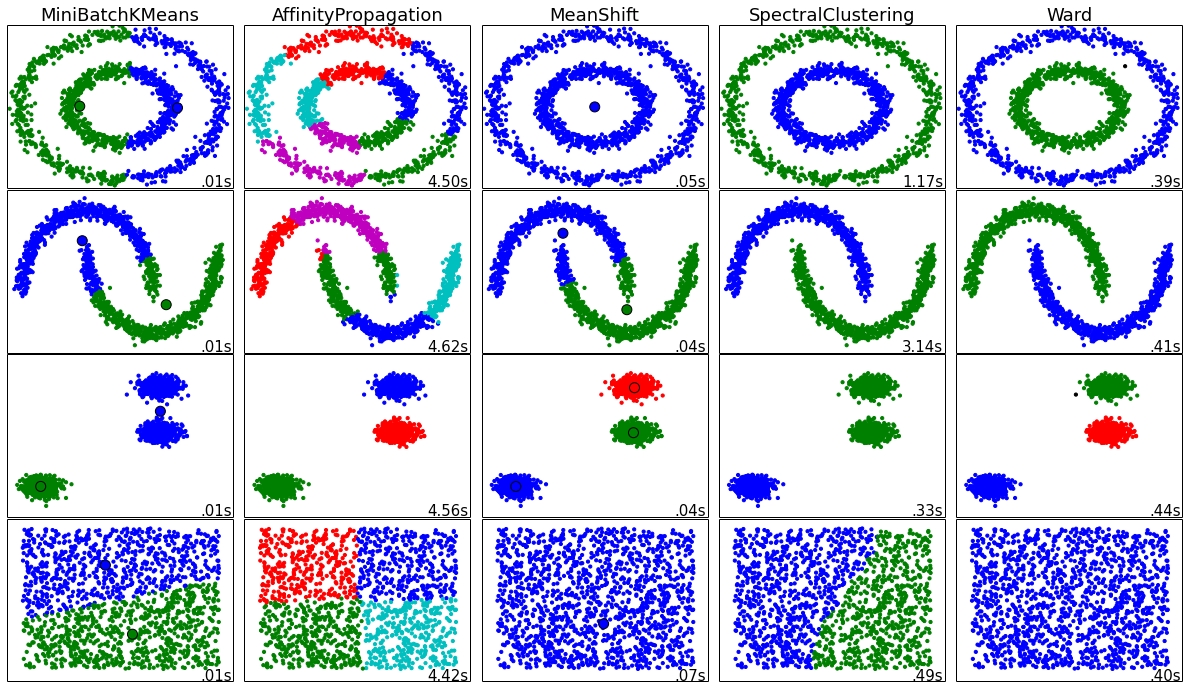

In [173]:
import sklearn
np.random.seed(0)

# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
n_samples = 1500
noisy_circles = sklearn.datasets.make_circles(n_samples=n_samples, factor=.5,noise=.05)
noisy_moons = sklearn.datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = sklearn.datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

clustering_names = [
    'MiniBatchKMeans', 'AffinityPropagation', 'MeanShift',
    'SpectralClustering', 'Ward',
    'DBSCAN', 'Birch']

plt.figure(figsize=(len(clustering_names) * 2 + 3, 9.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

ds = [noisy_circles, noisy_moons, blobs, no_structure]
for i_dataset, dataset in enumerate(ds):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=0.3)

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=10)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # create clustering estimators
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=2)    
    spectral = cluster.SpectralClustering(n_clusters=2,eigen_solver='arpack',affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=.2)
    affinity_propagation = cluster.AffinityPropagation(damping=.9,preference=-200)

    clustering_algorithms = [two_means, affinity_propagation, ms, spectral,dbscan]

    for name, algorithm in zip(clustering_names, clustering_algorithms):
        # predict cluster memberships
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        # plot
        plt.subplot(4, len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)
        plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)

        if hasattr(algorithm, 'cluster_centers_'):
            centers = algorithm.cluster_centers_
            center_colors = colors[:len(centers)]
            plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1
